In [1]:
# importing relevant modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
import plotly.express as px
import plotly.graph_objs as go

## Load and Preprocess Data

In [2]:
punjab_2=pd.read_csv("C:\Desktop\Smart Irrigation System\Punjab, India\PUNJAB_2_open-meteo-31.39N75.93E285m.csv")

In [3]:
punjab_2.describe().T

count        mean         std     min  \
temperature_2m (°C)                 35064.0   22.644804    7.910950   2.600   
relative_humidity_2m (%)            35064.0   68.007158   20.573979   9.000   
precipitation (mm)                  35064.0    0.098449    0.627933   0.000   
et0_fao_evapotranspiration (mm)     35064.0    0.161136    0.200862   0.000   
wind_speed_10m (km/h)               35064.0    7.661356    3.917377   0.000   
soil_temperature_28_to_100cm (°C)   35064.0   23.213661    5.373268  13.200   
soil_moisture_28_to_100cm (m³/m³)   35064.0    0.267997    0.054218   0.143   
shortwave_radiation_instant (W/m²)  35064.0  193.618384  265.318839   0.000   

                                       25%     50%      75%      max  
temperature_2m (°C)                 16.200  24.200   28.600   43.400  
relative_humidity_2m (%)            54.000  72.000   85.000  100.000  
precipitation (mm)                   0.000   0.000    0.000   26.200  
et0_fao_evapotranspiration (mm)      0.010   0.060    0.280    0.890  
wind_speed_10m (km/h)                5.100   7.000    9.400   44.900  
soil_temperature_28_to_100cm (°C)   18.600  24.300   28.300   31.100  
soil_moisture_28_to_100cm (m³/m³)    0.227   0.274    0.308    0.383  
shortwave_radiation_instant (W/m²)   0.000   0.000  385.300  949.200

In [4]:
punjab_2.head(3)

time  temperature_2m (°C)  relative_humidity_2m (%)  \
0  2020-01-01T00:00                  5.8                        98   
1  2020-01-01T01:00                  5.4                        99   
2  2020-01-01T02:00                  4.3                       100   

   precipitation (mm)  et0_fao_evapotranspiration (mm)  wind_speed_10m (km/h)  \
0                 0.0                              0.0                    7.8   
1                 0.0                              0.0                    3.3   
2                 0.0                              0.0                    2.9   

   soil_temperature_28_to_100cm (°C)  soil_moisture_28_to_100cm (m³/m³)  \
0                               13.6                              0.327   
1                               13.6                              0.327   
2                               13.5                              0.327   

   shortwave_radiation_instant (W/m²)  
0                                 0.0  
1                                 0.0  
2                                 0.0

In [5]:
# Convert timestamp to datetime and extract date
punjab_2['timestamp'] = pd.to_datetime(punjab_2['time'])
punjab_2['date'] = punjab_2['timestamp'].dt.date

In [6]:
punjab_2.head(2)

time  temperature_2m (°C)  relative_humidity_2m (%)  \
0  2020-01-01T00:00                  5.8                        98   
1  2020-01-01T01:00                  5.4                        99   

   precipitation (mm)  et0_fao_evapotranspiration (mm)  wind_speed_10m (km/h)  \
0                 0.0                              0.0                    7.8   
1                 0.0                              0.0                    3.3   

   soil_temperature_28_to_100cm (°C)  soil_moisture_28_to_100cm (m³/m³)  \
0                               13.6                              0.327   
1                               13.6                              0.327   

   shortwave_radiation_instant (W/m²)           timestamp        date  
0                                 0.0 2020-01-01 00:00:00  2020-01-01  
1                                 0.0 2020-01-01 01:00:00  2020-01-01

In [7]:
punjab_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   time                                35064 non-null  object        
 1   temperature_2m (°C)                 35064 non-null  float64       
 2   relative_humidity_2m (%)            35064 non-null  int64         
 3   precipitation (mm)                  35064 non-null  float64       
 4   et0_fao_evapotranspiration (mm)     35064 non-null  float64       
 5   wind_speed_10m (km/h)               35064 non-null  float64       
 6   soil_temperature_28_to_100cm (°C)   35064 non-null  float64       
 7   soil_moisture_28_to_100cm (m³/m³)   35064 non-null  float64       
 8   shortwave_radiation_instant (W/m²)  35064 non-null  float64       
 9   timestamp                           35064 non-null  datetime64[ns]
 10  date                  

# Feature Engineering

###  Aggregate Hourly ET₀ to Daily

In [8]:
# Rename ET₀ column for easier reference
punjab_2.rename(columns={'et0_fao_evapotranspiration (mm)': 'ET₀'}, inplace=True)

# Aggregate hourly ET₀ to daily ET₀
daily_et0 = punjab_2.groupby('date')['ET₀'].sum().reset_index()


### Apply Kc Values Based on Growth Stages

In [9]:
"""Define the crop coefficient (Kc) values for different growth stages of wheat:"""

'Define the crop coefficient (Kc) values for different growth stages of wheat:'

In [10]:
# Define growth stages with corresponding Kc values
growth_stages = {
    'initial': {'start': '2020-01-01', 'end': '2020-01-30', 'Kc': 0.35},
    'development': {'start': '2020-01-31', 'end': '2020-02-29', 'Kc': 0.75},
    'mid-season': {'start': '2020-03-01', 'end': '2020-04-30', 'Kc': 1.1},
    'late-season': {'start': '2020-05-01', 'end': '2020-05-31', 'Kc': 0.7}
}

def get_kc(date):
    for stage, info in growth_stages.items():
        if pd.to_datetime(info['start']) <= date <= pd.to_datetime(info['end']):
            return info['Kc']
    return 0.35  # Default to initial Kc if date doesn't match any stage

daily_et0['Kc'] = daily_et0['date'].apply(lambda x: get_kc(pd.to_datetime(x)))


### Calculate ETc

In [11]:
daily_et0['ETc'] = daily_et0['ET₀'] * daily_et0['Kc']


In [12]:
daily_et0

date   ET₀    Kc     ETc
0     2020-01-01  1.54  0.35  0.5390
1     2020-01-02  1.63  0.35  0.5705
2     2020-01-03  1.78  0.35  0.6230
3     2020-01-04  1.72  0.35  0.6020
4     2020-01-05  1.57  0.35  0.5495
...          ...   ...   ...     ...
1456  2023-12-27  1.79  0.35  0.6265
1457  2023-12-28  1.40  0.35  0.4900
1458  2023-12-29  1.52  0.35  0.5320
1459  2023-12-30  1.40  0.35  0.4900
1460  2023-12-31  1.35  0.35  0.4725

[1461 rows x 4 columns]

In [13]:
""""
In Punjab, the growing season for wheat typically aligns with the winter months and early spring. The specific timing can vary slightly based on local climate and agricultural practices, but generally, the growing season for wheat in Punjab spans from:

Sowing: October to November
Harvesting: March to April"""

'"\nIn Punjab, the growing season for wheat typically aligns with the winter months and early spring. The specific timing can vary slightly based on local climate and agricultural practices, but generally, the growing season for wheat in Punjab spans from:\n\nSowing: October to November\nHarvesting: March to April'

In [14]:
""""Crop Development Stage:
   - Duration: Approximately 30-40 days
   - Kc Value: 0.7 - 0.8
   - Description: This stage includes the development of the wheat crop, where water needs increase as the plants grow rapidly.

3. Mid-Season Stage:
   - Duration: Approximately 40-60 days
   - Kc Value: 1.0 - 1.2
   - Description: This is the peak growth period, including booting, heading, and grain filling. Water requirements are highest during this stage.

4. Late Season Stage:
   - Duration: Approximately 30-40 days
   - Kc Value: 0.6 - 0.8
   - Description: This stage includes maturation and ripening of the wheat crop. Water needs decrease as the crop approaches harvest.
"""

'"Crop Development Stage:\n   - Duration: Approximately 30-40 days\n   - Kc Value: 0.7 - 0.8\n   - Description: This stage includes the development of the wheat crop, where water needs increase as the plants grow rapidly.\n\n3. Mid-Season Stage:\n   - Duration: Approximately 40-60 days\n   - Kc Value: 1.0 - 1.2\n   - Description: This is the peak growth period, including booting, heading, and grain filling. Water requirements are highest during this stage.\n\n4. Late Season Stage:\n   - Duration: Approximately 30-40 days\n   - Kc Value: 0.6 - 0.8\n   - Description: This stage includes maturation and ripening of the wheat crop. Water needs decrease as the crop approaches harvest.\n'

### Distribute Daily ETc to Hourly Values

In [15]:
# Merge daily ETc back to the hourly dataframe
punjab_com = punjab_2.merge(daily_et0[['date', 'ETc']], on='date', how='left')

# Distribute daily ETc to hourly
punjab_com['hourly_ETc'] = punjab_com['ETc'] / 24


In [16]:
punjab_com.tail(5)

time  temperature_2m (°C)  relative_humidity_2m (%)  \
35059  2023-12-31T19:00                  7.9                       100   
35060  2023-12-31T20:00                  7.9                       100   
35061  2023-12-31T21:00                  8.2                        99   
35062  2023-12-31T22:00                  8.2                        99   
35063  2023-12-31T23:00                  8.3                        96   

       precipitation (mm)  ET₀  wind_speed_10m (km/h)  \
35059                 0.0  0.0                    5.8   
35060                 0.0  0.0                    5.7   
35061                 0.0  0.0                    5.5   
35062                 0.0  0.0                    4.7   
35063                 0.0  0.0                    4.8   

       soil_temperature_28_to_100cm (°C)  soil_moisture_28_to_100cm (m³/m³)  \
35059                               16.2                              0.291   
35060                               16.1                              0.291   
35061                               16.1                              0.291   
35062                               16.1                              0.291   
35063                               16.1                              0.291   

       shortwave_radiation_instant (W/m²)           timestamp        date  \
35059                                 0.0 2023-12-31 19:00:00  2023-12-31   
35060                                 0.0 2023-12-31 20:00:00  2023-12-31   
35061                                 0.0 2023-12-31 21:00:00  2023-12-31   
35062                                 0.0 2023-12-31 22:00:00  2023-12-31   
35063                                 0.0 2023-12-31 23:00:00  2023-12-31   

          ETc  hourly_ETc  
35059  0.4725    0.019688  
35060  0.4725    0.019688  
35061  0.4725    0.019688  
35062  0.4725    0.019688  
35063  0.4725    0.019688

### Determine Soil Water Deficit and Irrigation Needs

In [17]:
"""Define the soil moisture threshold and calculate irrigation needs:"""

'Define the soil moisture threshold and calculate irrigation needs:'

In [18]:
#threshold_soil_moisture = 0.15  # Example threshold in m³/m³

# Calculate soil deficit
#punjab_com['soil_deficit'] = punjab_com['hourly_ETc'] - punjab_com['precipitation (mm)']
#punjab_com['irrigation_need'] = punjab_com['soil_moisture_28_to_100cm (m³/m³)'] < threshold_soil_moisture

In [19]:
threshold_soil_moisture = 0.15  # Example threshold in m³/m³

# Calculate soil deficit
punjab_com['soil_deficit'] = punjab_com['hourly_ETc'] - punjab_com['precipitation (mm)']
punjab_com['irrigation_need'] = punjab_com['soil_moisture_28_to_100cm (m³/m³)'] < threshold_soil_moisture

def calculate_irrigation_need(soil_moisture, threshold, soil_deficit):
    if soil_moisture < threshold:
        return max(0, threshold - soil_moisture + soil_deficit)
    return 0

punjab_com['irrigation_amount'] = punjab_com.apply(lambda row: calculate_irrigation_need(
    row['soil_moisture_28_to_100cm (m³/m³)'], threshold_soil_moisture, row['soil_deficit']), axis=1)

# Create an irrigation schedule
irrigation_schedule = punjab_com[punjab_com['irrigation_need'] == True][['timestamp', 'irrigation_amount']]
irrigation_schedule


timestamp  irrigation_amount
11640 2021-04-30 00:00:00           0.095646
11641 2021-04-30 01:00:00           0.095646
11642 2021-04-30 02:00:00           0.095646
11643 2021-04-30 03:00:00           0.095646
11644 2021-04-30 04:00:00           0.095646
...                   ...                ...
30079 2023-06-07 07:00:00           0.077833
30080 2023-06-07 08:00:00           0.077833
30081 2023-06-07 09:00:00           0.077833
30082 2023-06-07 10:00:00           0.077833
30083 2023-06-07 11:00:00           0.077833

[240 rows x 2 columns]

In [20]:
irrigation_schedule.head(50)

timestamp  irrigation_amount
11640 2021-04-30 00:00:00           0.095646
11641 2021-04-30 01:00:00           0.095646
11642 2021-04-30 02:00:00           0.095646
11643 2021-04-30 03:00:00           0.095646
11644 2021-04-30 04:00:00           0.095646
11645 2021-04-30 05:00:00           0.095646
11646 2021-04-30 06:00:00           0.095646
11647 2021-04-30 07:00:00           0.095646
11648 2021-04-30 08:00:00           0.095646
11649 2021-04-30 09:00:00           0.095646
11650 2021-04-30 10:00:00           0.095646
11651 2021-04-30 11:00:00           0.095646
12000 2021-05-15 00:00:00           0.087125
12001 2021-05-15 01:00:00           0.087125
12002 2021-05-15 02:00:00           0.087125
12003 2021-05-15 03:00:00           0.087125
12004 2021-05-15 04:00:00           0.087125
12005 2021-05-15 05:00:00           0.087125
12006 2021-05-15 06:00:00           0.087125
12007 2021-05-15 07:00:00           0.087125
12008 2021-05-15 08:00:00           0.087125
12009 2021-05-15 09:00:00           0.087125
12010 2021-05-15 10:00:00           0.087125
12011 2021-05-15 11:00:00           0.087125
12012 2021-05-15 12:00:00           0.087125
12013 2021-05-15 13:00:00           0.087125
12014 2021-05-15 14:00:00           0.087125
12015 2021-05-15 15:00:00           0.087125
12016 2021-05-15 16:00:00           0.087125
12017 2021-05-15 17:00:00           0.087125
12018 2021-05-15 18:00:00           0.087125
12019 2021-05-15 19:00:00           0.087125
12020 2021-05-15 20:00:00           0.087125
12021 2021-05-15 21:00:00           0.087125
12022 2021-05-15 22:00:00           0.087125
12023 2021-05-15 23:00:00           0.087125
12024 2021-05-16 00:00:00           0.099937
12025 2021-05-16 01:00:00           0.099937
12026 2021-05-16 02:00:00           0.099937
12027 2021-05-16 03:00:00           0.099937
12028 2021-05-16 04:00:00           0.099937
12029 2021-05-16 05:00:00           0.099937
12030 2021-05-16 06:00:00           0.099937
12031 2021-05-16 07:00:00           0.099937
12032 2021-05-16 08:00:00           0.098937
12033 2021-05-16 09:00:00           0.098937
12034 2021-05-16 10:00:00           0.098937
12035 2021-05-16 11:00:00           0.098937
12036 2021-05-16 12:00:00           0.101938
12037 2021-05-16 13:00:00           0.101938

In [21]:
punjab_com.head(3)

time  temperature_2m (°C)  relative_humidity_2m (%)  \
0  2020-01-01T00:00                  5.8                        98   
1  2020-01-01T01:00                  5.4                        99   
2  2020-01-01T02:00                  4.3                       100   

   precipitation (mm)  ET₀  wind_speed_10m (km/h)  \
0                 0.0  0.0                    7.8   
1                 0.0  0.0                    3.3   
2                 0.0  0.0                    2.9   

   soil_temperature_28_to_100cm (°C)  soil_moisture_28_to_100cm (m³/m³)  \
0                               13.6                              0.327   
1                               13.6                              0.327   
2                               13.5                              0.327   

   shortwave_radiation_instant (W/m²)           timestamp        date    ETc  \
0                                 0.0 2020-01-01 00:00:00  2020-01-01  0.539   
1                                 0.0 2020-01-01 01:00:00  2020-01-01  0.539   
2                                 0.0 2020-01-01 02:00:00  2020-01-01  0.539   

   hourly_ETc  soil_deficit  irrigation_need  irrigation_amount  
0    0.022458      0.022458            False                0.0  
1    0.022458      0.022458            False                0.0  
2    0.022458      0.022458            False                0.0

## EDA

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


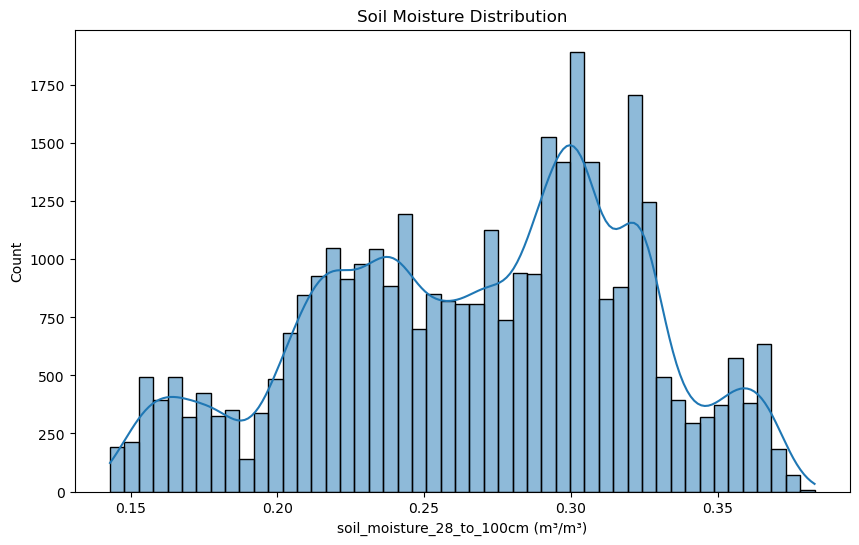

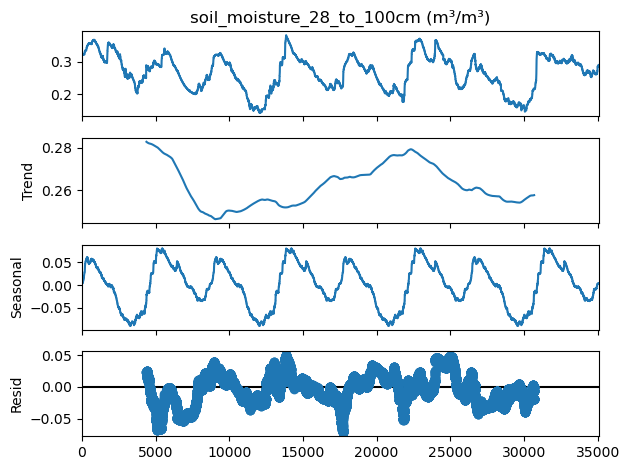

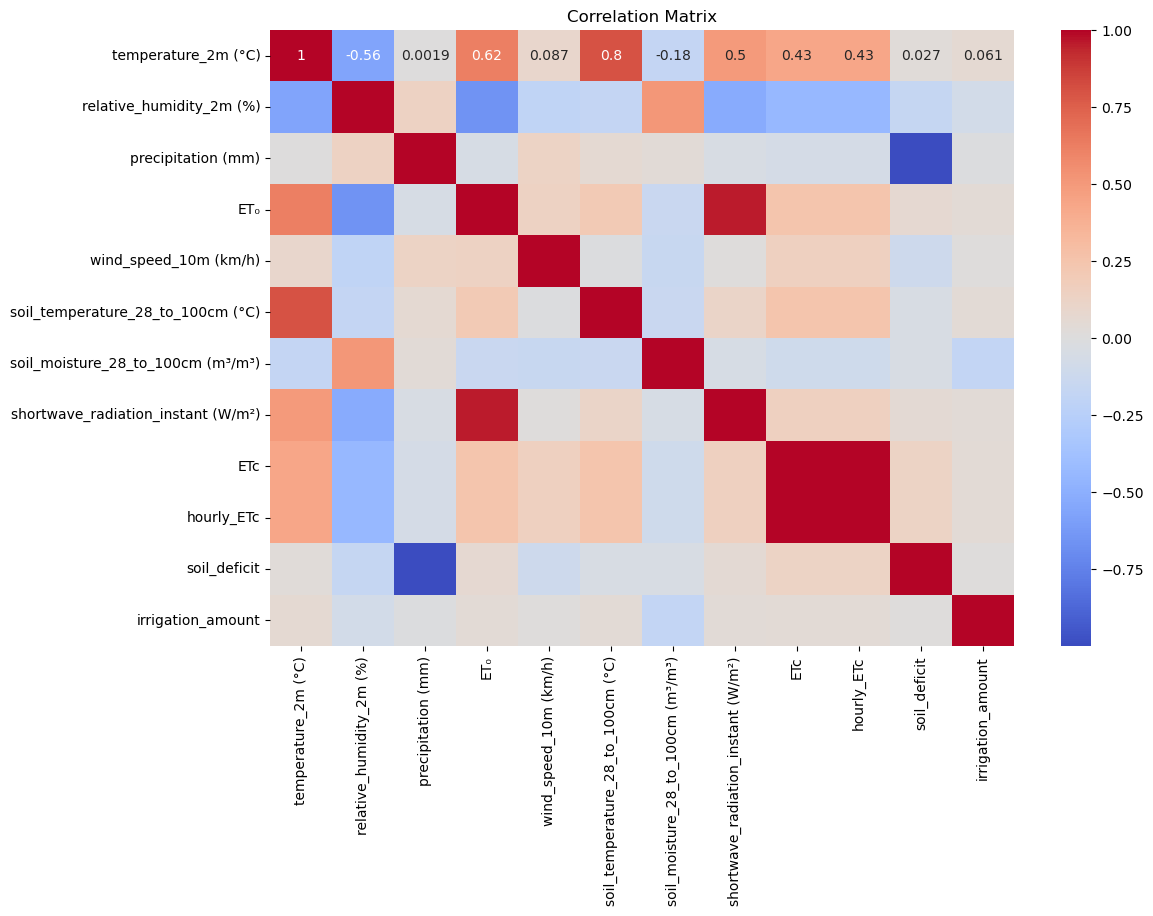

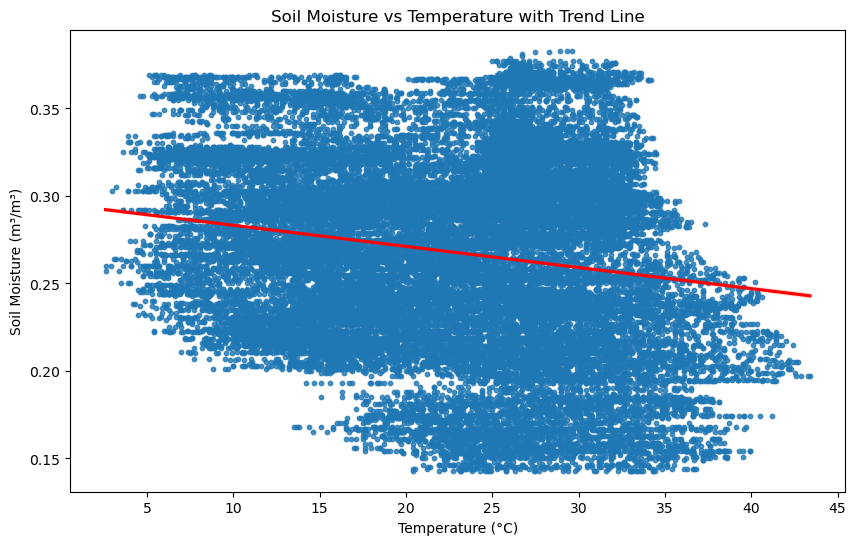

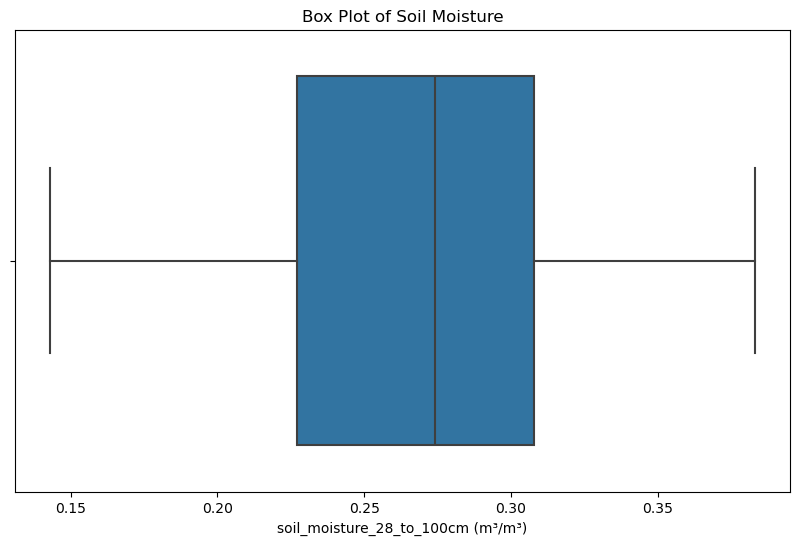

In [22]:

# Convert 'time' column to datetime
#punjab_com['time'] = pd.to_datetime(punjab_com['time'])

# Set 'time' column as index
#punjab_com.set_index('time', inplace=True)


# Distribution analysis
plt.figure(figsize=(10, 6))
sns.histplot(punjab_com['soil_moisture_28_to_100cm (m³/m³)'], kde=True)
plt.title('Soil Moisture Distribution')
plt.show()

# Time series analysis
#plt.figure(figsize=(12, 6))
#plt.plot(punjab_com.index, punjab_com['soil_moisture_28_to_100cm (m³/m³)'])
#plt.title('Soil Moisture Over Time')
#plt.xlabel('Time')
#plt.ylabel('Soil Moisture (m³/m³)')
#plt.show()

# Seasonal decomposition
decomposition = seasonal_decompose(punjab_com['soil_moisture_28_to_100cm (m³/m³)'], model='additive', period=24*365)
decomposition.plot()
plt.show()

# Correlation analysis
numeric_cols = punjab_com.select_dtypes(include=[np.number]).columns
corr_matrix = punjab_com[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Scatter plot with trend line: Soil Moisture vs Temperature
plt.figure(figsize=(10, 6))
sns.regplot(x='temperature_2m (°C)', y='soil_moisture_28_to_100cm (m³/m³)', data=punjab_com, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Soil Moisture vs Temperature with Trend Line')
plt.xlabel('Temperature (°C)')
plt.ylabel('Soil Moisture (m³/m³)')
plt.show()

# Anomaly detection: Box plot for soil moisture
plt.figure(figsize=(10, 6))
sns.boxplot(x=punjab_com['soil_moisture_28_to_100cm (m³/m³)'])
plt.title('Box Plot of Soil Moisture')
plt.show()


In [23]:
punjab_com

time  temperature_2m (°C)  relative_humidity_2m (%)  \
0      2020-01-01T00:00                  5.8                        98   
1      2020-01-01T01:00                  5.4                        99   
2      2020-01-01T02:00                  4.3                       100   
3      2020-01-01T03:00                  5.7                        98   
4      2020-01-01T04:00                  7.9                        94   
...                 ...                  ...                       ...   
35059  2023-12-31T19:00                  7.9                       100   
35060  2023-12-31T20:00                  7.9                       100   
35061  2023-12-31T21:00                  8.2                        99   
35062  2023-12-31T22:00                  8.2                        99   
35063  2023-12-31T23:00                  8.3                        96   

       precipitation (mm)   ET₀  wind_speed_10m (km/h)  \
0                     0.0  0.00                    7.8   
1                     0.0  0.00                    3.3   
2                     0.0  0.00                    2.9   
3                     0.0  0.01                    3.6   
4                     0.0  0.06                    3.1   
...                   ...   ...                    ...   
35059                 0.0  0.00                    5.8   
35060                 0.0  0.00                    5.7   
35061                 0.0  0.00                    5.5   
35062                 0.0  0.00                    4.7   
35063                 0.0  0.00                    4.8   

       soil_temperature_28_to_100cm (°C)  soil_moisture_28_to_100cm (m³/m³)  \
0                                   13.6                              0.327   
1                                   13.6                              0.327   
2                                   13.5                              0.327   
3                                   13.5                              0.327   
4                                   13.5                              0.327   
...                                  ...                                ...   
35059                               16.2                              0.291   
35060                               16.1                              0.291   
35061                               16.1                              0.291   
35062                               16.1                              0.291   
35063                               16.1                              0.291   

       shortwave_radiation_instant (W/m²)           timestamp        date  \
0                                     0.0 2020-01-01 00:00:00  2020-01-01   
1                                     0.0 2020-01-01 01:00:00  2020-01-01   
2                                     0.0 2020-01-01 02:00:00  2020-01-01   
3                                    81.8 2020-01-01 03:00:00  2020-01-01   
4                                   194.1 2020-01-01 04:00:00  2020-01-01   
...                                   ...                 ...         ...   
35059                                 0.0 2023-12-31 19:00:00  2023-12-31   
35060                                 0.0 2023-12-31 20:00:00  2023-12-31   
35061                                 0.0 2023-12-31 21:00:00  2023-12-31   
35062                                 0.0 2023-12-31 22:00:00  2023-12-31   
35063                                 0.0 2023-12-31 23:00:00  2023-12-31   

          ETc  hourly_ETc  soil_deficit  irrigation_need  irrigation_amount  
0      0.5390    0.022458      0.022458            False                0.0  
1      0.5390    0.022458      0.022458            False                0.0  
2      0.5390    0.022458      0.022458            False                0.0  
3      0.5390    0.022458      0.022458            False                0.0  
4      0.5390    0.022458      0.022458            False                0.0  
...       ...         ...           ...              ...                ...  
35059  0.4725

In [24]:
#punjab.set_index('Time', inplace=True)

# Create a Plotly figure using plotly.express
fig = px.line(punjab_com, x=punjab_com.index, y='soil_moisture_28_to_100cm (m³/m³)', title='Soil Moisture Over Time')

# Update x-axis and y-axis titles
fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Soil Moisture (m³/m³)')

# Show the figure
fig.show()

In [25]:
#punjab.set_index('Time', inplace=True)

# Create a Plotly figure using plotly.express
fig = px.line(punjab_com, x=punjab_com.index, y='temperature_2m (°C)', title='Temperature Over Time')

# Update x-axis and y-axis titles
fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Temperature_2m (°C))')

# Show the figure
fig.show()

In [26]:
#punjab.set_index('Time', inplace=True)

# Create a Plotly figure using plotly.express
fig = px.line(punjab_com, x=punjab_com.index, y='precipitation (mm)', title='Precipitation Over Time')

# Update x-axis and y-axis titles
fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Precipitation (mm)	')

# Show the figure
fig.show()

In [27]:
#punjab_com.set_index('Time', inplace=True)

# Create a Plotly figure using plotly.express
fig = px.line(punjab_com, x=punjab_com.index, y="soil_temperature_28_to_100cm (°C)", title="Soil Temperature Over Time")

# Update x-axis and y-axis titles
fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Soil_temperature_28_to_100cm (°C)')

# Show the figure
fig.show()

In [28]:
#punjab.set_index('Time', inplace=True)

# Create a Plotly figure using plotly.express
fig = px.line(punjab_com, x=punjab_com.index, y='wind_speed_10m (km/h)', title='(Wind speed Over Time')

# Update x-axis and y-axis titles
fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Wind_speed_10m (km/h)')

# Show the figure
fig.show()

In [29]:


#punjab.set_index('Time', inplace=True)

# Create a Plotly figure using plotly.express
fig = px.line(punjab_com, x=punjab_com.index, y='relative_humidity_2m (%)', title='(Relaive humidity Over Time')

# Update x-axis and y-axis titles
fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Relative_humidity_2m (%)')

# Show the figure
fig.show()

In [30]:
print("Hello World!")

Hello World!
